In [1]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels as sm
import folium
import sys
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import ccf, ccovf
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import warnings 
warnings.filterwarnings('ignore')

__Introduction__

In this part, we will discuss what will happen on the death cases if we change the daily average temperature for California. Note that the daily average temperature is significant in predicting death cases, we may modify the daily average temperature __10 degree higher__ and __10 degree lower__ to see what will happen.

__Importing Data__

In [2]:
df_covid = pd.read_csv("us_daily_processed.csv")
us_state_date_confirmed = df_covid.groupby(['Province_State','date'])['Confirmed'].sum().reset_index()
us_state_date_death = df_covid.groupby(['Province_State','date'])['Deaths'].sum().reset_index()
df_confirmed_bystate = pd.DataFrame(us_state_date_confirmed)
df_death_bystate = pd.DataFrame(us_state_date_death)
df_temp= pd.read_csv("COVID_19_us_temp.csv")
df_temp= df_temp.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df_temp_bystate=df_temp.groupby(["Province_State","date"])['Avg','Confirmed','Deaths'].sum().reset_index()
df_temp_bystate=pd.DataFrame(df_temp_bystate)

In [3]:
def select_data(state):
    df1=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    return df1

__California__

For predicting the death cases, we recommend ARIMA(1,1,0) using temperature.Thereofore, we can change the average temperature to see what will happen to the predicted death cases.

The daily average temperature in the test data is given by
[63.3 65.5 68.  68.1 74.7 75.3 72.8 64.8 61.5 61.  59.6 62.  65.6 68.2
 64.6 61.1 60.4 64.3 69.  66.1 70.1 73.8]


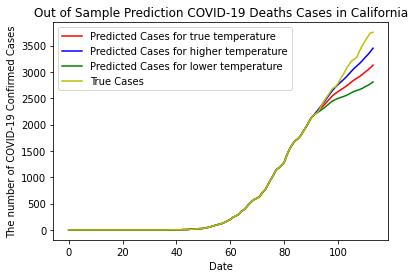

In [21]:
ts_tot=select_data('California')
n_sample = ts_tot.shape[0]
n_train=int(0.8*n_sample)+1
n_forecast=n_sample-n_train
ts_deaths = ts_tot['Deaths']
ts_tempe = ts_tot['Avg']
ts_deaths = pd.DataFrame(ts_deaths)
ts_tempe = pd.DataFrame(ts_tempe)
ts_train_d = ts_deaths.iloc[:n_train]['Deaths']
ts_test_d = ts_deaths.iloc[n_train:]['Deaths']
ts_train_t = ts_tempe.iloc[:n_train]['Avg']
ts_test_t = ts_tempe.iloc[n_train:]['Avg']

### Prediction using true daily temperature
model2=ARIMA(endog=ts_train_d,order=(1,1,0),exog=ts_train_t)
model2_fit = model2.fit(disp=0)
predictions2 = model2_fit.forecast(steps=len(ts_test_d),exog=ts_test_t)[0]
### Prediction using modified daily temperature
new_test_t1=np.array(ts_test_t)+10
new_test_t2=np.array(ts_test_t)-10
predictions3 = model2_fit.forecast(steps=len(ts_test_d),exog=new_test_t1)[0]
predictions4 = model2_fit.forecast(steps=len(ts_test_d),exog=new_test_t2)[0]
### Visualization
ts_test_d_np=np.array(ts_test_d)
ts_train_d_np=np.array(ts_train_d)
print("The daily average temperature in the test data is given by")
print(np.array(ts_test_t))
ts_pred_d1=[]
ts_pred_d2=[]
ts_pred_d3=[]
ts_true_d=[]
for i in range(len(ts_train_d)):
    t2=ts_train_d_np[i]
    ts_pred_d1.append(int(t2))
    ts_pred_d2.append(int(t2))
    ts_pred_d3.append(int(t2))
    ts_true_d.append(int(t2))
for i in range(len(ts_test_d)):
    t2=predictions2[i]
    t3=predictions3[i]
    t4=predictions4[i]
    ts_pred_d1.append(int(t2))
    ts_pred_d2.append(int(t3))
    ts_pred_d3.append(int(t4))
    ts_true_d.append(int(ts_test_d_np[i]))
        
plt.plot(ts_pred_d1,'r',label='Predicted Cases for true temperature')
plt.plot(ts_pred_d2,'b',label='Predicted Cases for higher temperature')
plt.plot(ts_pred_d3,'g',label='Predicted Cases for lower temperature')
plt.plot(ts_true_d,'y',label='True Cases')
plt.xlabel('Date')
plt.ylabel('The number of COVID-19 Confirmed Cases')
plt.title('Out of Sample Prediction COVID-19 Deaths Cases in California')
plt.legend()
plt.show()  

### Discussion

Based on the visualization above, we see that when we had a higher temperature, there would be more death cases in California. On the other hand, there would be less death cases in California when we had lower temperature. This results is consistent with positivity of coefficient for average temperature in predicting death cases.

However, we should be careful on this issue. There are various kinds of sub-types of coronovirus, their comfortable zone for the temperature range would be different. Besides, there are many biological features that will affect the activity of virus, for example, the health condition for each confirmed case. Other biological features should be carefully considered.